In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact
import matplotlib.patches as matpatch
from descartes.patch import PolygonPatch
from shapely.ops import cascaded_union, polygonize
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
#from scipy.integrate import quad, dblquad
#from scipy import interpolate
import shapely.geometry as sg
import descartes
#from scipy import optimize 
from mpl_toolkits.mplot3d import Axes3D
#import sobol_seq
%matplotlib notebook

# Алгоритм Монте-Карло для нахождения площади сложной фигуры

<img src="2rpr.jpg">

https://www.researchgate.net/publication/245038755_Workspace_optimization_and_kinematic_performance_evaluation_of_2DOF_parallel_mechanisms

### Робот 2-RPR
Робот состоит из двух штанг переменной длинны и известно расстояние между основаниями штанг

Задача: найти площадь рабочей области робота и нарисовать её

In [7]:
def check_circ_lit(x, y, x0, y0, r):#проверяем лежит ли точка вне малой окр-ти
    """
    Check point if it is outside lower limit of leg (what is the same if these points outside the smallest circles)
    
    Parameters
    ----------
    x, y : float, the coordinates of points
    x0, y0 : float, the coordinates of the circle's center
    r : float, radius of the circle
    Returns
    -------
    Boolean massive of all points which are outside the smallest circles
    
    """
    return (((x - x0)**2 + (y - y0)**2) >= r**2)

In [8]:
def check_circ_big(x, y, x0, y0, r):#проверяем лежит ли точка вне малой окр-ти
    """
    Check points if it is inside the higher limit of leg (what is the same if these points inside the biggest circles)
    
    Parameters
    ----------
    x, y : float, the coordinates of points
    x0, y0 : float, the coordinates of the circle's center
    r : float, radius of the circle
    Returns
    -------
    Boolean massive of all points which are inside the biggest circles
    
    return ((x - x0)**2 + (y - y0)**2 <= r**2)
    
    """
    return ((x - x0)**2 + (y - y0)**2 <= r**2)

In [9]:
l1_l = 3
l2_l = 3
l1_h = 15
l2_h = 15

In [10]:
def cond_numb(l1, l2, d):
    #sol = optimize.root(fun, [0, 0], method='hybr')
    #x = sol.x
    x1 = 0
    x2 = 0
    k = 0
    T = 0
    S = 0
    M = 0
    eps1=1
    J = np.array([[0 , 0],
                [0, 0]])
    if (l1 + l2>=d) and (l1 + d>=l2) and (l2 + d>=l1):
    #if (l1 + l2==d+eps1) and (l1 + d>=l2):
        x1 = (d**2+l1**2-l2**2)/(2*d)
        x2 = math.sqrt((l1**2-x1**2))
        J_teta = np.array([[l1, 0],
                       [0, l2]])
        J_x = np.array([[x1, x2],
                   [x1-d, x2]])
        if (np.linalg.det(J_x) != 0) and (np.linalg.det(J_teta) != 0):
            J = np.dot(-np.linalg.inv(J_teta), J_x)
            k = np.linalg.norm(J)*np.linalg.norm(np.linalg.inv(J))
            #T = (np.linalg.norm(np.eye(2))**2)/(np.linalg.norm(J)*np.linalg.norm(np.linalg.inv(J)))
            #S = np.linalg.norm(np.linalg.inv(np.dot(J,J.T)))*np.linalg.norm(np.dot(J,J.T))
            #M = np.linalg.det(J)
            #print(k, T, S, M)
    return(k, x1, x2)

In [11]:
def square_calc(d, l1_l, l1_h):
    n = 10
    L1_x = np.linspace(l1_l+(l1_h-l1_l)/n/2, l1_h-(l1_h-l1_l)/n/2, n-1)
    L2_x = np.linspace(l1_l+(l1_h-l1_l)/n/2, l1_h-(l1_h-l1_l)/n/2, n-1)
    L1_x, L2_x = np.meshgrid(L1_x, L2_x)
    K_mat_x = np.zeros([n-1, n-1])
    s = 0
    sq = ((l1_h-l1_l)/n)**2
    for i in range(n-1):
        for j in range(n-1):
            p = cond_numb(L1_x[i, j], L2_x[i,j], d)[0]
            if p!=0:
                K_mat_x[i, j] = 1/p
            s+=  K_mat_x[i, j] #K_mat[i,j]
    return(s/n**2)

In [13]:
l_l_min  = 1
l_l_max = 8
l_h_min = 9
l_h_max  = 16
p = 25000
LL = np.zeros((l_l_max-l_l_min+1, l_h_max - l_h_min+1))
area_LL = np.zeros((l_l_max-l_l_min+1, l_h_max - l_h_min+1))
for i in range(l_l_min, l_l_max+1):
    for j in range(l_h_min, l_h_max+1):
        LL[i - l_l_min,j - l_h_min] = square_calc(6, i, j)
        area_LL[i - l_l_min,j - l_h_min] = Monte_Carlo(i, i, j, j, 6, p)[0]

In [64]:
area_LL[0, 0]

71.0748

In [ ]:
#if (area_LL[i-l_l_min,j - l_h_min]>area_LL[i-l_l_min-1,j - l_h_min]) and (LL[i-l_l_min,j - l_h_min]>LL[i-l_l_min-1,j - l_h_min]):
    #    print(i,j)

<IPython.core.display.Javascript object>


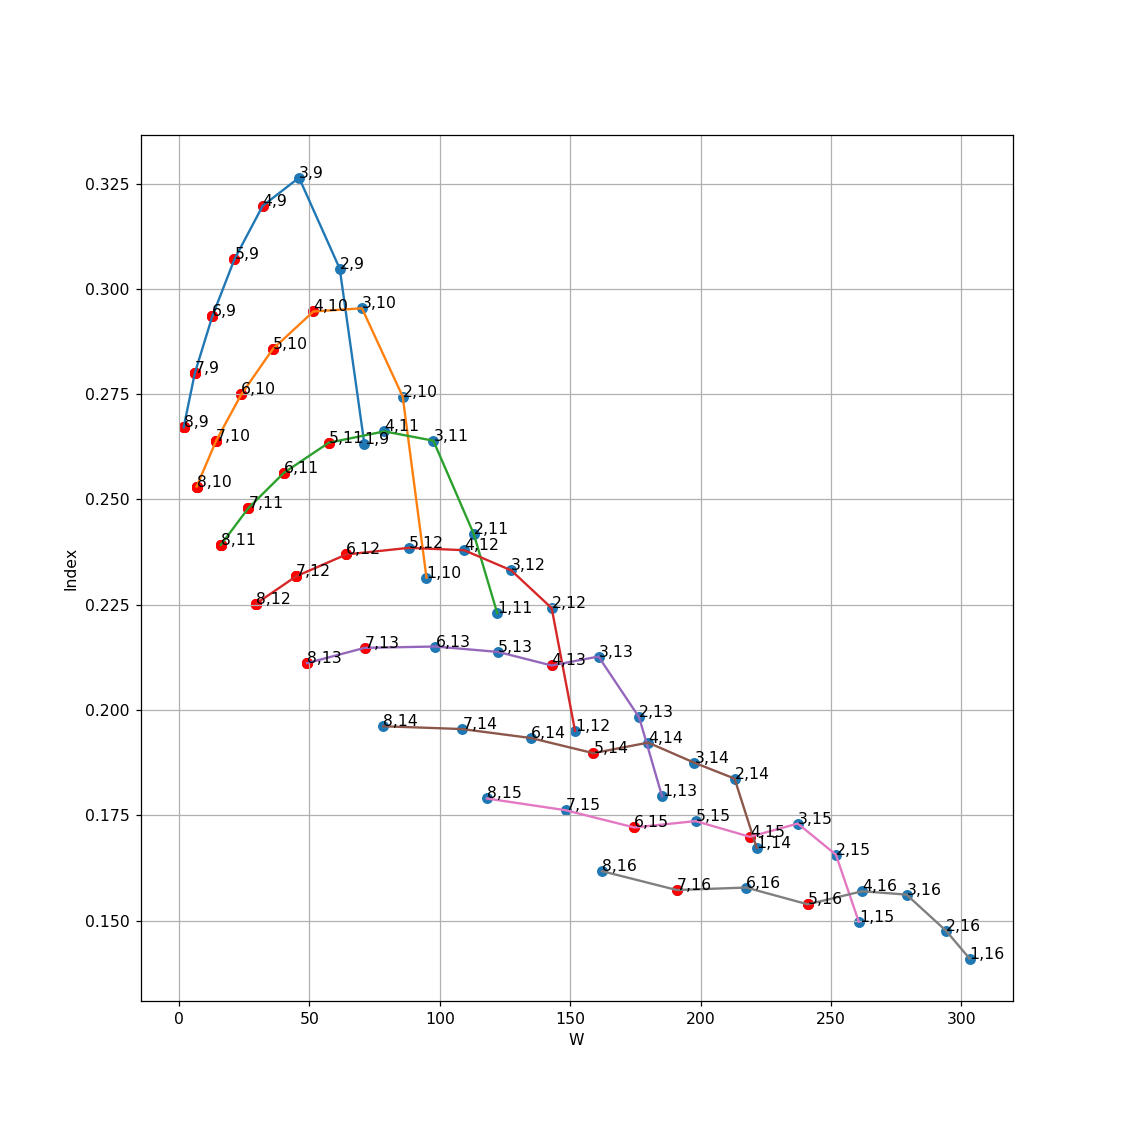

In [91]:
#dd = np.linspace(1,l1_l+l2_h,l1_l+l2_h-1)
nice = []
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
#ax1.set_title('The dependency of Index from W')
ax1.plot(area_LL, LL)
#ax1.plot(bad_area, bad_squ)
ax1.set_ylabel('Index')
ax1.set_xlabel('W')
ax1.scatter(area_LL, LL)
#print('Значение индекса = ', squ[np.argmax(squ)])
#print('Значение площади = ',area[np.argmax(squ)])
#print('d =',np.argmax(squ)+1)
#ax1.legend ( ("lmin c [1, 8], lmax = 9", "lmin c [1, 8], lmax = 10", "lmin c [1, 8], lmax = 11",
#              "lmin c [1, 8], lmax = 12", "lmin c [1, 8], lmax = 13", "lmin c [1, 8], lmax = 14",
#              "lmin c [1, 8], lmax = 15", "lmin c [1, 8], lmax = 16") )
for i in range(l_l_min, l_l_max+1):
    for j in range(l_h_min, l_h_max+1):
        ax1.text(area_LL[i-l_l_min,j - l_h_min], 
                LL[i-l_l_min,j - l_h_min], s =str(i) + ',' + str(j))
o = 0
#for j in range(l_l_max - l_l_min):
   # for i in range(l_h_max - l_h_min):
        #print(i + l_l_min, j + l_h_min)
        #if (area_LL[i + 1, j]>area_LL[i, j]) and (LL[i + 1, j]>LL[i, j]):
        #print(area_LL[i + 1, j], area_LL[i, j])
        #o = o + 1
for j in range(l_h_max - l_h_min+1):
    #print(j + l_h_min)
    for i in range(l_l_max - l_l_min+1):
        for k in range(i+1, l_l_max - l_l_min+1):
            #print(i + l_l_min, k + l_l_min)
           # print(LL[i, j], LL[k, j])
            #print(area_LL[i, j], area_LL[k, j])
            #print(i+ l_l_min,j+ l_h_min, k+ l_l_min)
            if (area_LL[i, j]>area_LL[k, j]) & (LL[i, j]>LL[k, j]):
                #fig = plt.figure(figsize=(10, 10))
                #ax1 = fig.add_subplot(111)
                #ax1.scatter(area_LL[])
                #print(k + l_l_min, j + l_h_min)
                nice.append([k, j])
                ax1.scatter(area_LL[k, j], LL[k, j], c='r')
ax1.grid()

<IPython.core.display.Javascript object>


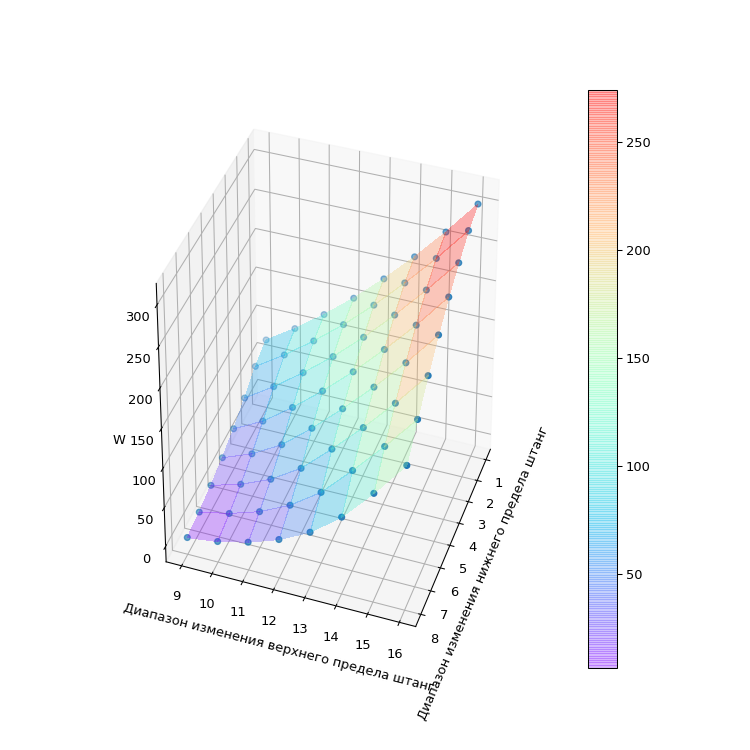

In [92]:
L1, L2 = np.meshgrid(np.linspace(l_l_min, l_l_max,  -l_l_min+l_l_max+1), 
                     np.linspace(l_h_min, l_h_max,  -l_h_min+l_h_max+1))
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
#ax1 = fig.add_subplot(111, projection='3d', frame_on=False)
#ax1.set_title('The dependency of Index from W')

ax.scatter(L1, L2, area_LL.T)
surf = ax.plot_surface(L1, L2, area_LL.T, cmap='rainbow',
                           linewidth=0.1, antialiased=False, alpha = 0.3)
#ax.scatter(L1, L2, LL.T)
#surf1 = ax.plot_surface(L1, L2, LL.T, cmap='rainbow',
#                           linewidth=0.1, antialiased=False, alpha = 0.3)
ax.set_ylabel('Диапазон изменения верхнего предела штанг')
ax.set_xlabel('Диапазон изменения нижнего предела штанг')
ax.set_zlabel('W')
cbar = fig.colorbar(surf, ax = ax)#ax.grid()

<IPython.core.display.Javascript object>


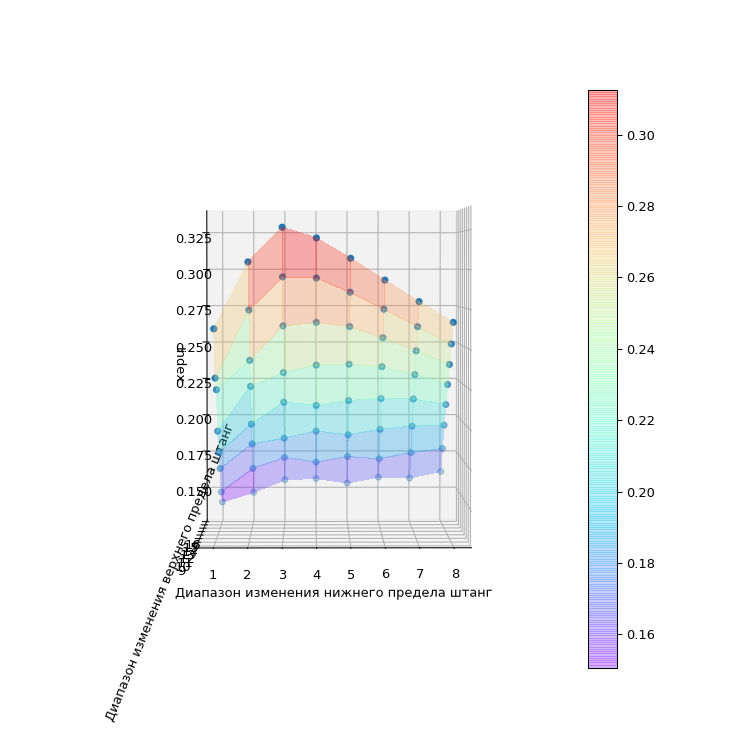

In [93]:
L1, L2 = np.meshgrid(np.linspace(l_l_min, l_l_max,  -l_l_min+l_l_max+1), 
                     np.linspace(l_h_min, l_h_max,  -l_h_min+l_h_max+1))
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
#ax1.set_title('The dependency of Index from W')
#for i in range(1, l1_l + l1_h):
ax.scatter(L1, L2, LL.T)
surf = ax.plot_surface(L1, L2, LL.T, cmap='rainbow',
                           linewidth=0.1, antialiased=False, alpha = 0.3)
ax.set_ylabel('Диапазон изменения верхнего предела штанг')
ax.set_xlabel('Диапазон изменения нижнего предела штанг')
ax.set_zlabel('Index')
cbar = fig.colorbar(surf, ax = ax)
ax.grid()

In [26]:
p = 25000
bad_squ = []
bad_area = []
good_squ = []
good_area = []
bad_d = []
good_d = []
squ = np.zeros(l1_l+l2_h-1)
area = np.zeros(l1_l+l2_h-1)
for i in range(1, l1_l+l2_h):
    squ[i-1] = square_calc(i, l1_l, l1_h)
    area[i-1] = Monte_Carlo(l1_l, l2_l, l1_h, l2_h, i, p)[0]

for i in range(1, l1_l+l2_h):    
    if area[i-1]<area[np.argmax(squ)]:
        bad_squ.append(squ[i-1])
        bad_area.append(area[i-1])
        bad_d.append(i)
    else:
        good_squ.append(squ[i-1])
        good_area.append(area[i-1])
        good_d.append(i)
        #print(squ[i-1] , area[i-1], i)

In [27]:
good_area

[320.1006,
 302.826,
 285.1056,
 268.3536,
 252.042,
 237.303,
 222.735,
 208.0344,
 192.9744,
 177.735,
 163.3644,
 149.7636]

In [12]:
"""
dd = np.linspace(1,l1_l+l2_h,l1_l+l2_h-1)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_ylabel('W')
ax1.set_xlabel('d')
    #ax1.set_title('1/The condition number of Jacobian matrix')
ax1.set_zlabel('Index')
surf = ax1.scatter(dd, area, squ, cmap='rainbow',
                           linewidth=0.1, antialiased=False, alpha = 0.3)
"""

"\ndd = np.linspace(1,l1_l+l2_h,l1_l+l2_h-1)\nfig = plt.figure(figsize=(10, 10))\nax1 = fig.add_subplot(111, projection='3d')\nax1.set_ylabel('W')\nax1.set_xlabel('d')\n    #ax1.set_title('1/The condition number of Jacobian matrix')\nax1.set_zlabel('Index')\nsurf = ax1.scatter(dd, area, squ, cmap='rainbow',\n                           linewidth=0.1, antialiased=False, alpha = 0.3)\n"

<IPython.core.display.Javascript object>


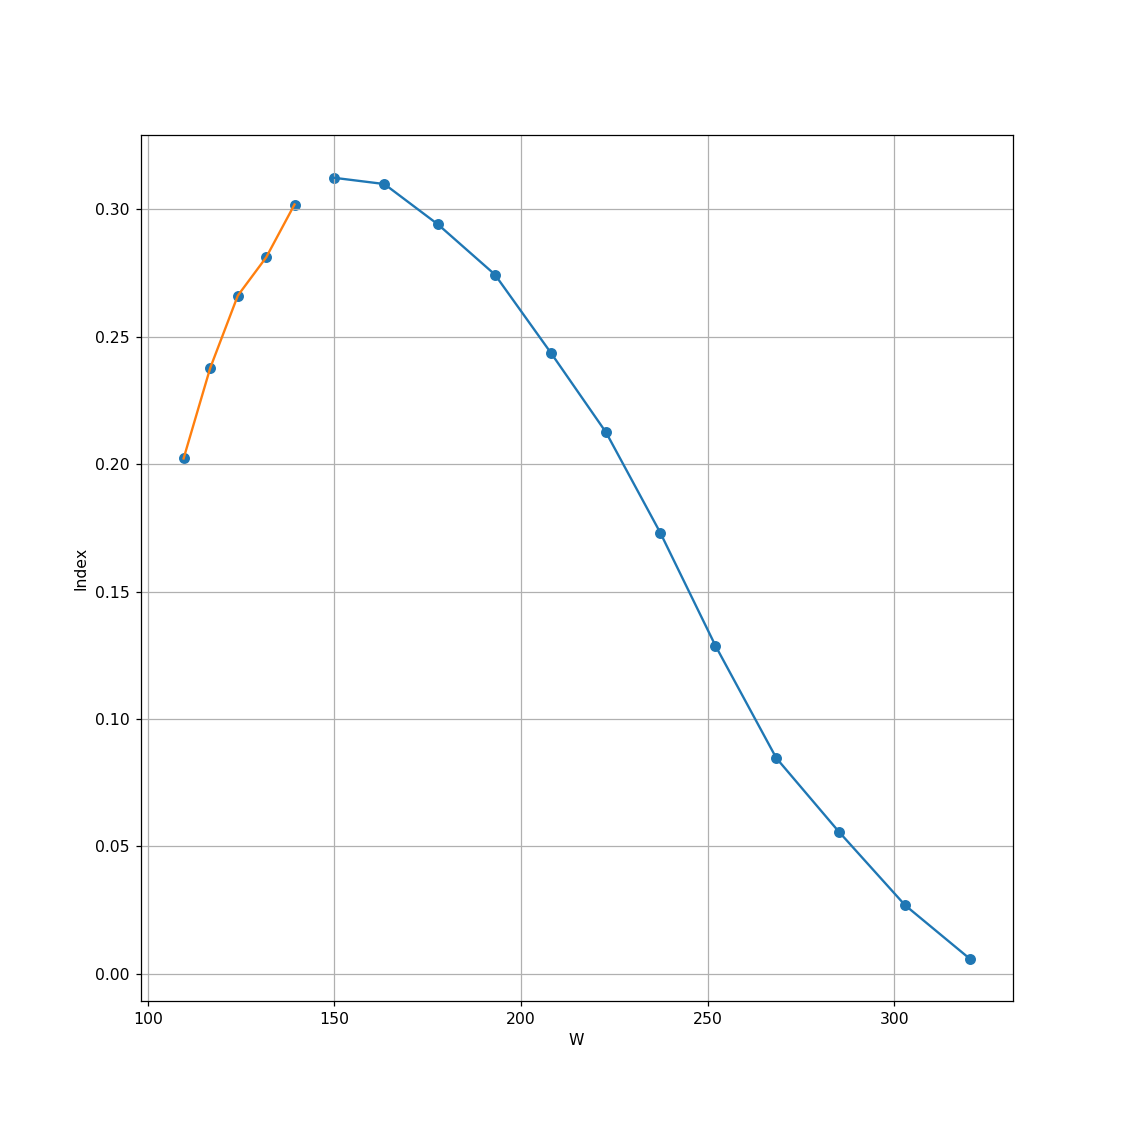

Значение индекса =  0.3124248561935755
Значение площади =  149.7636
d = 12


"\nax2 = fig.add_subplot(312)\nax2.set_title('The dependency of Index from d')\nax2.plot(dd, squ)\nax2.set_ylabel('Index')\nax2.set_xlabel('d')\nax2.grid()\n\n\nax3 = fig.add_subplot(313)\nax3.set_title('The dependency of Area from d')\nax3.plot(dd, area)\nax3.set_ylabel('W')\nax3.set_xlabel('d')\nax3.grid()\n\n"

In [34]:
dd = np.linspace(1,l1_l+l2_h,l1_l+l2_h-1)
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
#ax1.set_title('The dependency of Index from W')
ax1.plot(good_area, good_squ)
ax1.plot(bad_area, bad_squ)
ax1.set_ylabel('Index')
ax1.set_xlabel('W')
ax1.scatter(area, squ)
print('Значение индекса = ', squ[np.argmax(squ)])
print('Значение площади = ',area[np.argmax(squ)])
print('d =',np.argmax(squ)+1)
ax1.grid()
"""
ax2 = fig.add_subplot(312)
ax2.set_title('The dependency of Index from d')
ax2.plot(dd, squ)
ax2.set_ylabel('Index')
ax2.set_xlabel('d')
ax2.grid()


ax3 = fig.add_subplot(313)
ax3.set_title('The dependency of Area from d')
ax3.plot(dd, area)
ax3.set_ylabel('W')
ax3.set_xlabel('d')
ax3.grid()

"""

<IPython.core.display.Javascript object>


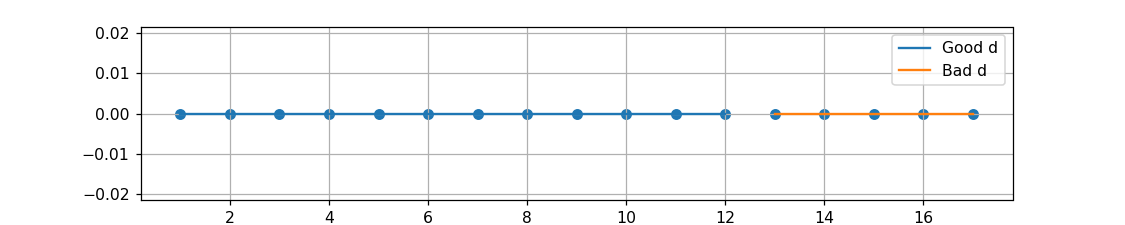

In [29]:
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)
#ax1.set_title('The dependency of Index from W')
#for i in range(1, l1_l + l1_h):
ax.scatter(np.linspace(1,l1_l + l1_h-1, l1_l + l1_h-1 ),np.zeros(l1_l + l1_h-1))
ax.plot(good_d,  np.zeros(len(good_d)), label = 'Good d')
ax.plot(bad_d,  np.zeros(len(bad_d)), label = 'Bad d')
ax.set_xlabel('d')
ax.legend()
ax1.set_xlim([0, 1])
ax.grid()

In [30]:
def visual_cond_numb_num(d):
    n = 13
    L1_x = np.linspace(l1_l+(l1_h-l1_l)/n/2, l1_h-(l1_h-l1_l)/n/2, n-1)
    L2_x = np.linspace(l1_l+(l1_h-l1_l)/n/2, l1_h-(l1_h-l1_l)/n/2, n-1)
    L1_x, L2_x = np.meshgrid(L1_x, L2_x)
    K_mat_x = np.zeros([n-1, n-1])
    s = 0
    s1 = 0
    s2 = 0
    sq = ((l1_h-l1_l)/n)**2
    L11 = np.linspace(l1_l, l1_h, n)
    L22 = np.linspace(l2_l, l2_h, n)
    K_mat = np.zeros([n, n])
    L1, L2 = np.meshgrid(L11, L22)
    for i in range(n):
        for j in range(n):
            p1 = cond_numb(L1[i, j], L2[i,j], d)[0]
            if p1!=0:
                K_mat[i, j] = 1/p1
            s2+=K_mat[i ,j]
            #T_mat[i, j] = cond_numb(i, j, d)[1]
            #if cond_numb(i, j, d)[2]!=0:
            #    S_mat[i-l1_l,j-l2_l] = 1/cond_numb(i, j, d)[2]
            #else:
            #    S_mat[i-l1_l,j-l2_l] = cond_numb(i, j, d)[2]
            #M_mat[i-l1_l,j-l2_l] = cond_numb(i, j, d)[3]
    #        X[i, j] = cond_numb(L1[i, j], L2[i,j], d)[1]
    #        Y[i, j] = cond_numb(L1[i, j], L2[i,j], d)[2]
    for i in range(n-1):
        for j in range(n-1):
            p = cond_numb(L1_x[i, j], L2_x[i,j], d)[0]
            if p!=0:
                K_mat_x[i, j] = 1/p
            s+= sq * K_mat_x[i, j] #K_mat[i,j]
            s1+= K_mat_x[i, j]
    print('Площадь индекс c делением на площадь',s/(l1_h-l1_l)**2)
    print('Площадь индекса с делением на n^2',s1/(n**2))
    
    #print('Площадь равна c умножением на площадь',s)
    #print('Площадь равна',s1)

    fig = plt.figure(figsize=(10, 10))
    
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.set_ylabel('l2')
    ax1.set_xlabel('l1')
    ax1.set_title('1/The condition number of Jacobian matrix')
    ax1.set_zlabel('1/k')
    surf = ax1.plot_surface(L1, L2, K_mat, cmap='rainbow',
                           linewidth=0.1, antialiased=False, alpha = 0.3)
    ax1.scatter(L1_x, L2_x, K_mat_x)
    ax1.scatter(L1, L2, K_mat, c='r')

In [31]:
interact(visual_cond_numb_num, d=(3,15))

interactive(children=(IntSlider(value=9, description='d', max=15, min=3), Output()), _dom_classes=('widget-int…

<function __main__.visual_cond_numb_num(d)>

In [32]:
def visual_cond_numb(d):
    n=13
    L11 = np.linspace(l1_l, l1_h, n)
    L22 = np.linspace(l2_l, l2_h, n)
    #print(l1_l, l1_h, l1_h-l1_l)
    L1, L2 = np.meshgrid(L11, L22)
    L1_x = np.linspace(l1_l+(l1_h-l1_l)/n/2, l1_h-(l1_h-l1_l)/n/2, n-1)
    L2_x = np.linspace(l1_l+(l1_h-l1_l)/n/2, l1_h-(l1_h-l1_l)/n/2, n-1)
    L1_x, L2_x = np.meshgrid(L1_x, L2_x)
    K_mat = np.zeros([n, n])
    K_mat_x = np.zeros([n-1, n-1])
    #T_mat = np.zeros([n, n])
    #S_mat = np.zeros([n, n])
    #M_mat = np.zeros([n, n])
    X = np.zeros([n, n])
    Y = np.zeros([n, n])
    s = 0
    for i in range(n):
        for j in range(n):
            p1 = cond_numb(L1[i, j], L2[i,j], d)[0]
            if p1!=0:
                K_mat[i, j] = 1/p1
            X[i, j] = cond_numb(L1[i, j], L2[i,j], d)[1]
            Y[i, j] = cond_numb(L1[i, j], L2[i,j], d)[2] 
    fig = plt.figure(figsize=(8, 8))
    """
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.set_ylabel('l2')
    ax1.set_xlabel('l1')
    ax1.set_title('The condition number of Jacobian matrix')
    ax1.set_zlabel('1/k')
    surf = ax1.plot_surface(L1, L2, K_mat, cmap='rainbow',
                           linewidth=0.1, antialiased=False)
    cbar = fig.colorbar(surf, ax = ax1)
    ax1.grid()
    """
    ax5 = fig.add_subplot(111, projection='3d')
    ax5.set_ylabel('y')
    ax5.set_xlabel('x')
    ax5.set_zlabel('1/K')
   # ax5.set_title('1/the condition number of Jacobian matrix from ')
    surf3 = ax5.plot_surface(X, Y, K_mat, cmap='rainbow',
                         linewidth=0.1, antialiased=False, alpha = 0.5)
   # ax5.scatter(X, Y, K_mat, c='r')
    cbar = fig.colorbar(surf3, ax = ax5)
    ax5.grid()
    """
    ax2 = fig.add_subplot(313)
    ax2.set_ylabel('y')
    ax2.set_xlabel('x')
    ax2.scatter(X, Y)
    ax2.grid()
    """

In [33]:
interact(visual_cond_numb, d=(3,15))

interactive(children=(IntSlider(value=9, description='d', max=15, min=3), Output()), _dom_classes=('widget-int…

<function __main__.visual_cond_numb(d)>

### Алгоритм Монте-Карло
1) Ограничим нашу рабочую область прямоугольником с известными сторонами

2) Заполним прямоугольник случайным образом $N$-точками

3) Площадь искомой области будет вычисляться по формуле: $S=\dfrac{(b-a)\cdot (c-d) \cdot  K}{N}$, где $a$ и $b$ - левая и правая границы интегрирования, $с$ и $d$ - верхняя и нижняя границы интегрирования, $K$ - кол-во точек, которые попали в искомую область

Все точки рабочей области должны удоволетворять условиям, что они вне малых окружностей и внутри больших окружностей

In [12]:
def Monte_Carlo(l1_l, l2_l, l1_h, l2_h, d, p, seed=1234):
    """ 
    Compute the area of 2-RPR robot's workspace with Monte Carlo method
    
    Parameters
    ----------
    l1_l, l2_l : float, the lowest limit of legs
    l1_h, l2_h : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    prng = np.random.RandomState(seed)
    Xp = (-l2_h**2 + l1_h**2 + d**2)/(2*d)
    Yp = math.sqrt(l1_h**2 - Xp**2)
    if l1_h <= l2_h:
        Yh = l1_h
    else:
        Yh = l2_h
    Xl = d - l2_h
    Xh = l1_h+abs(d - l2_h)
    Yl = 0
    X = prng.uniform(Xl, Xh, size=p)
    Y = prng.uniform(Yl, Yh, size=p)
    c = 0
    c = sum((check_circ_lit(X, Y, 0, 0, l1_l)) & (check_circ_lit(X, Y, d, 0, l2_l)) &
            (check_circ_big(X, Y, d, 0, l2_h)) & (check_circ_big(X, Y, 0, 0, l1_h)))
    area = ((Xh-Xl)*Yh*c/p)
    return area, Xl, Xh, Yl, Yh

In [66]:
def Ravnomern_net(l1_l, l2_l, l1_h, l2_h, d, p, seed=1234):
    """ 
    Compute the area of 2-RPR robot's workspace with Monte Carlo method
    
    Parameters
    ----------
    l1_l, l2_l : float, the lowest limit of legs
    l1_h, l2_h : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    prng = np.random.RandomState(seed)
    Xp = (-l2_h**2 + l1_h**2 + d**2)/(2*d)
    Yp = math.sqrt(l1_h**2 - Xp**2)
    if l1_h <= l2_h:
        Yh = l1_h
    else:
        Yh = l2_h
    Xl = d - l2_h
    Xh = l1_h+abs(d - l2_h)
    Yl = 0
    X1 = np.linspace(Xl, Xh+Xl, p)
    Y1 = np.linspace(Yl, Yh, p)
    X, Y = np.meshgrid(X1, Y1)
    X = X.ravel()
    Y = Y.ravel()
    c = 0
    c = sum((check_circ_lit(X, Y, 0, 0, l1_l)) & (check_circ_lit(X, Y, d, 0, l2_l)) &
            (check_circ_big(X, Y, d, 0, l2_h)) & (check_circ_big(X, Y, 0, 0, l1_h)))
    print(Xh,Xl,Yh,c,p)
    area = ((Xh-Xl)*Yh*c/p**2)
    return area, Xl, Xh, Yl, Yh

In [67]:
def draw_and_compute(l1_l, l2_l, l1_h, l2_h, d):
    """ 
    Draw the workspace of 2-RPR robot, computing its area with shapely and MC-algorithm 
    
    Parameters
    ----------
    l1_l, l2_l : float, the lowest limit of legs
    l1_h, l2_h : float, the highest limit of legs
    d : float, length between legs of the robot
    Returns
    -------
    
    """
    p=100000
    Ax=[]
    Ay=[]
    if (l1_l<l1_h) and (l2_l<l2_h):
        area,Xl,Xh,Yl,Yh=Monte_Carlo(l1_l,l2_l,l1_h,l2_h,d,p)
        area_ravn = Ravnomern_net(l1_l,l2_l,l1_h,l2_h,d,100)[0]
        X1 = np.linspace(Xl, Xh+Xl, 10)
        Y1 = np.linspace(Yl, Yh, 10)
        X, Y = np.meshgrid(X1, Y1)
        l1_l+=0.00000000000001
        l2_l+=0.00000000000001
        fig, ax = plt.subplots()
        x_min, y_min, x_max, y_max=-l1_h-1,-l1_h-1,d+l2_h+1,l2_h+1
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        a = sg.Point(0,0).buffer(l1_l)# задаём оркужности через shapely, чтобы построить пересечение колец и найти площадь пересечения
        b = sg.Point(0,0).buffer(l1_h)
        c = sg.Point(d,0).buffer(l2_l)
        e = sg.Point(d,0).buffer(l2_h)
        ab=b.difference(a)# строим кольца из большой и малой окружности
        cd=e.difference(c)
        middle = ab.intersection(cd)
        print('Площадь через алгоритм Монте-Карло =',area)
        print('Площадь через равномерную сетку =',area_ravn)
        print('Приблизительное значение площади, посчитанная через shapely =',middle.area/2)
        circle1 = Circle((0, 0), radius=l1_l, fill=False, color='r')# задаём окружности через matplotlib
        circle2 = Circle((0, 0), radius=l1_h, fill=False, color='r')
        circle3 = Circle((d, 0), radius=l2_l, fill=False, color='b')
        circle4 = Circle((d, 0), radius=l2_h, fill=False, color='b')
        rect1=Rectangle([Xl,Yl],Xh,Yh, fill=False, color='g', linewidth=2.0)
        ax.add_patch(descartes.PolygonPatch(middle, fc='b', ec='k', alpha=0.2))# отрисовываем
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(circle3)
        ax.add_patch(circle4)
        ax.add_patch(rect1)
        #ax.scatter(X,Y)
        ax.grid()
        ax.axes.set_aspect('equal')
    else:
        print('Неверные данные')

### Рабочая область 2-RPR
Рабочая область робота представляет собой пересечение колец, образованных попарно окружностями малых и больших длин каждой штанги, так же стоит отметить, что эта область симметрична относително оси Х и нам достаточно будет найти площадь верхней(или нижней) полуплоскости. 

In [68]:
interact(draw_and_compute, l1_l=(3,15), l2_l=(3,15), l1_h=(5,20), l2_h=(5,20), d=(3,15))

interactive(children=(IntSlider(value=9, description='l1_l', max=15, min=3), IntSlider(value=9, description='l…

<function __main__.draw_and_compute(l1_l, l2_l, l1_h, l2_h, d)>